In [2]:
import pandas as pd
from sqlite3 import connect
import seaborn as sns
import matplotlib as plt

# Segmentation des clients de l'entreprise Olist

In [3]:
date_fin = '\'2025-06-12\''

sql_query = f"""
WITH favourite_product as (
SELECT
    customer_id,
    product_category_name as produit_prefere
FROM
    (SELECT
        o.customer_id,
        p.product_category_name,
        count(p.product_id) as nb_products_by_category,
        ROW_NUMBER() OVER (
                PARTITION BY o.customer_id 
                ORDER BY COUNT(p.product_id) DESC
            ) AS rang
    FROM orders o
    JOIN order_items i ON i.order_id=o.order_id
    JOIN products p ON p.product_id=i.product_id
    GROUP BY o.customer_id, p.product_category_name)
WHERE rang=1
)

SELECT 
    c.customer_id,
    c.customer_state,
    count(o.order_id) as nb_commandes,
    count(i.product_id) as nb_produits,
    sum(i.price) as depense_totale,
    (julianday({date_fin})-julianday(MAX(o.order_purchase_timestamp))) as recence,
    AVG(r.review_score) as score_moyen,
    f.produit_prefere as type_produit_prefere
FROM customers c
JOIN orders o ON c.customer_id=o.customer_id
JOIN order_items i ON i.order_id=o.order_id
JOIN order_reviews r ON o.order_id=r.order_id
JOIN favourite_product f ON f.customer_id=c.customer_id
GROUP BY c.customer_id, c.customer_state;
"""

conn = connect(database= 'olist.db')
data = pd.read_sql(
    sql_query, 
    conn)
print(data.shape)
print(data.dtypes)
data.head()

(97917, 8)
customer_id              object
customer_state           object
nb_commandes              int64
nb_produits               int64
depense_totale          float64
recence                 float64
score_moyen             float64
type_produit_prefere     object
dtype: object


,customer_id,customer_state,nb_commandes,nb_produits,depense_totale,recence,score_moyen,type_produit_prefere
0,00012a2ce6f8dcda20d059ce98491703,SP,1,1,89.80,2766.327477,1.0,brinquedos
1,000161a058600d5901f007fab4c27140,MG,1,1,54.90,2887.596852,4.0,beleza_saude
2,0001fd6190edaaf884bcaf3d49edf079,ES,1,1,179.99,3025.537002,5.0,bebes
3,0002414f95344307404f0ace7a26f1d5,MG,1,1,149.90,2856.451852,5.0,cool_stuff
4,000379cdec625522490c315e70c7a9fb,SP,1,1,93.00,2627.428970,4.0,cama_mesa_banho


In [7]:
data.describe()

,nb_commandes,nb_produits,depense_totale,recence
count,95458.000000,95458.00000,95458.000000,95458.000000
mean,1.033606,1.18010,142.383495,2716.907166
std,0.210013,0.62076,217.603881,153.174489
min,1.000000,1.00000,0.850000,2473.620174
25%,1.000000,1.00000,47.900000,2592.611855
50%,1.000000,1.00000,89.890000,2697.405891
75%,1.000000,1.00000,155.000000,2826.214656
max,16.000000,24.00000,13440.000000,3202.114363


<Axes: xlabel='nb_commandes', ylabel='Count'>

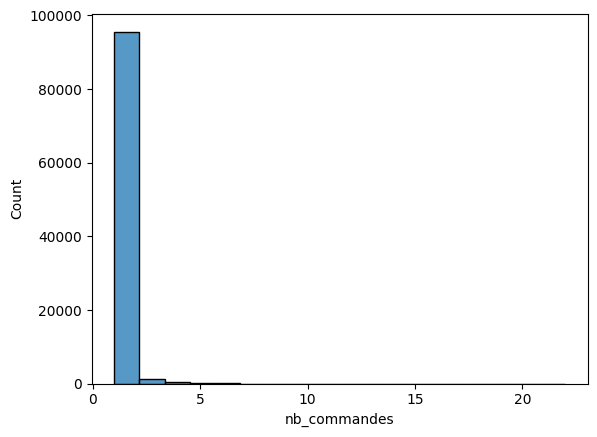

In [4]:
plusieurs_commandes = data.loc[data['nb_commandes']>1,'nb_commandes']
# plusieurs_commandes
sns.histplot(data['nb_commandes'])

<Axes: xlabel='nb_produits', ylabel='Count'>

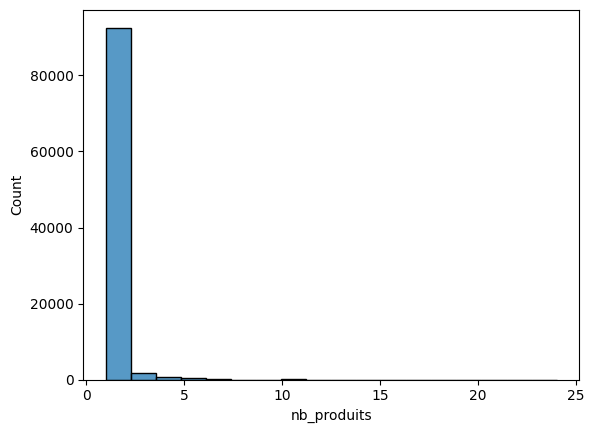

In [6]:
sns.histplot(data['nb_produits'])

<Axes: xlabel='recence', ylabel='Count'>

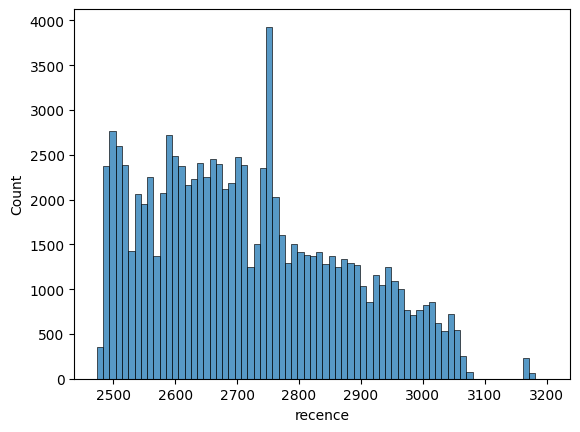

In [9]:
sns.histplot(data['recence'])

<Axes: xlabel='depense_totale', ylabel='Count'>

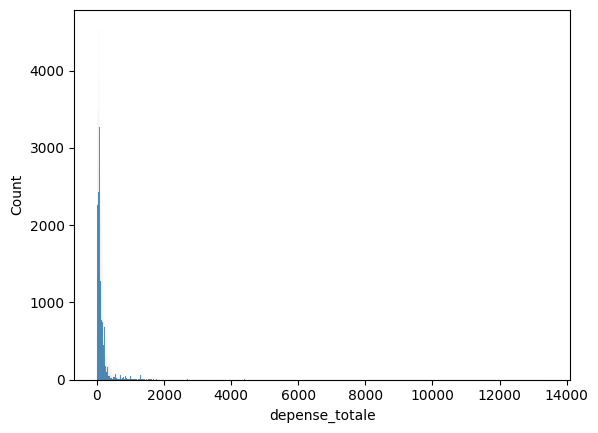

In [13]:
sns.histplot(data['depense_totale'])

<Axes: ylabel='depense_totale'>

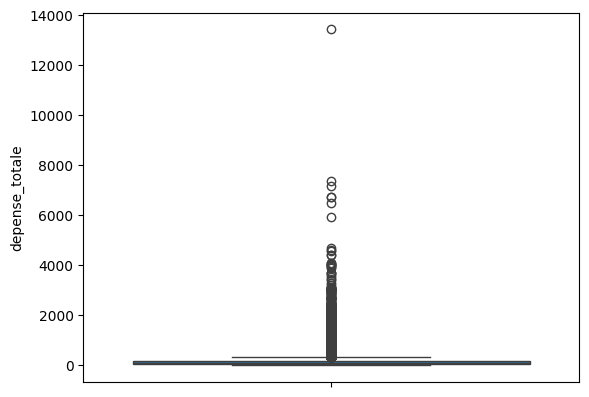

In [14]:
sns.boxplot(data['depense_totale'])

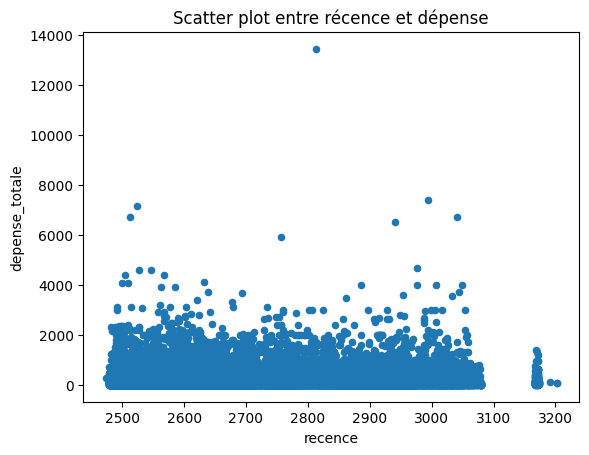

In [18]:
data.plot.scatter(x='recence', y='depense_totale', title= "Scatter plot entre récence et dépense");

                nb_commandes  nb_produits  depense_totale   recence
nb_commandes        1.000000     0.437239        0.105379 -0.021747
nb_produits         0.437239     1.000000        0.188666 -0.010911
depense_totale      0.105379     0.188666        1.000000  0.001020
recence            -0.021747    -0.010911        0.001020  1.000000


<Axes: >

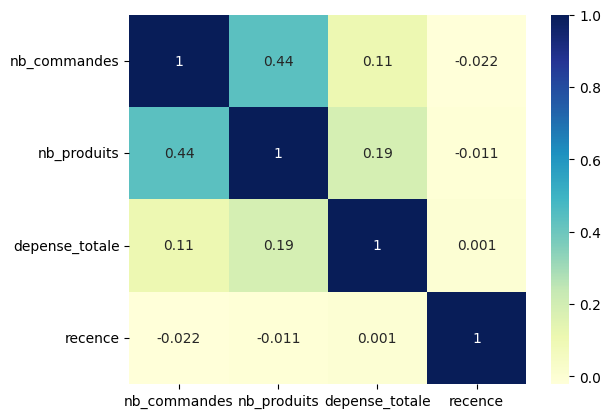

In [22]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = data.select_dtypes(include=numerics)


matrix = numeric_df.corr(method = 'pearson')
print(matrix)

sns.heatmap(matrix, cmap="YlGnBu", annot=True)

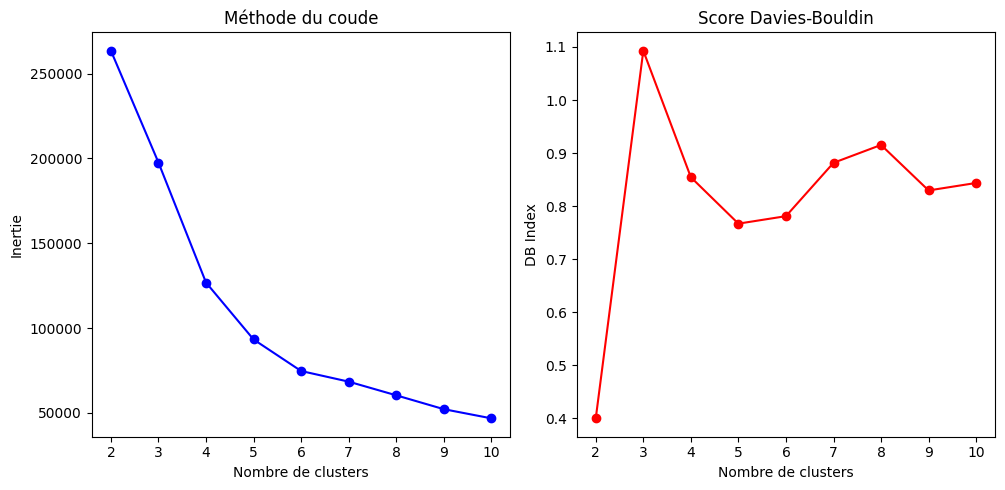


Recommandations pour K basées sur les différentes méthodes:
Méthode du coude: K = 10
Davies-Bouldin: K = 2


In [26]:
import pandas as pd
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

# Préparation des données
pt = PowerTransformer(method='yeo-johnson')
X_transformed = pt.fit_transform(numeric_df)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

# Calcul des métriques pour différents nombres de clusters
range_clusters = range(2, 11)
silhouette_scores = []
db_scores = []
inertia_values = []

for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    db_avg = davies_bouldin_score(X_scaled, cluster_labels)
    inertia = kmeans.inertia_
    
    # silhouette_scores.append(silhouette_avg)
    db_scores.append(db_avg)
    inertia_values.append(inertia)

# Visualisation des résultats
plt.figure(figsize=(15, 5))

# Graphique inertie
plt.subplot(131)
plt.plot(range_clusters, inertia_values, 'b-', marker='o')
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')

# Graphique Davies-Bouldin
plt.subplot(132)
plt.plot(range_clusters, db_scores, 'r-', marker='o')
plt.title('Score Davies-Bouldin')
plt.xlabel('Nombre de clusters')
plt.ylabel('DB Index')

# # Graphique Silhouette
# plt.subplot(133)
# plt.plot(range_clusters, silhouette_scores, 'g-', marker='o')
# plt.title('Score Silhouette')
# plt.xlabel('Nombre de clusters')
# plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Sélection du meilleur nombre de clusters
best_k_inertia = range_clusters[np.argmax(np.gradient(inertia_values))]
best_k_db = range_clusters[np.argmin(db_scores)]
# best_k_silhouette = range_clusters[np.argmax(silhouette_scores)]

print(f"\nRecommandations pour K basées sur les différentes méthodes:")
print(f"Méthode du coude: K = {best_k_inertia}")
print(f"Davies-Bouldin: K = {best_k_db}")
# print(f"Silhouette: K = {best_k_silhouette}")

# Application finale du K-means avec le K choisi
# k_choisi = best_k_silhouette  # Choisissez celui qui vous convient le mieux
# final_kmeans = KMeans(n_clusters=k_choisi, random_state=42)
# final_clusters = final_kmeans.fit_predict(X_scaled)

# # Affichage des scores finaux
# print(f"\nScores pour K = {k_choisi}:")
# print(f"Inertie: {final_kmeans.inertia_}")
# print(f"Score Silhouette: {silhouette_score(X_scaled, final_clusters)}")
# print(f"Davies-Bouldin Index: {davies_bouldin_score(X_scaled, final_clusters)}")